In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf                 
from tensorflow import keras            
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import (      # ⬅️  agrupa todo aquí
    Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D,
    Dense, Dropout, Concatenate, Lambda
)


In [51]:
train_df = pd.read_csv("train.csv")
val_df   = pd.read_csv("val.csv")
test_df  = pd.read_csv("test.csv")

train_df["split"] = "train"
val_df["split"]   = "validation"
test_df["split"]  = "test"
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [ ]:

MAX_LEN = 1156              
def parse_and_pad(col, maxlen=MAX_LEN):
    vecs = df[col].apply(lambda x: np.array(eval(x)))
    return pad_sequences(vecs, maxlen=maxlen, padding="post", dtype="float32")

x1 = np.expand_dims(parse_and_pad("code1_vecMark"), -1)
x2 = np.expand_dims(parse_and_pad("code2_vecMark"), -1)
y  = df["result"].values
splits = df["split"]

x1_train, x1_val, x1_test = x1[splits=="train"], x1[splits=="validation"], x1[splits=="test"]
x2_train, x2_val, x2_test = x2[splits=="train"], x2[splits=="validation"], x2[splits=="test"]
y_train,  y_val,  y_test  = y[splits=="train"],  y[splits=="validation"],  y[splits=="test"]





In [ ]:
vec_len = train_df["code1_vecMark"].iloc[0]
print(len(eval(vec_len)))   


1156


Arquitectura tipo SCNN

In [ ]:
def build_scnn_branch(input_shape, filters=(128,128,256), kernels=(5,7,9), pool=2):
    inp = Input(shape=input_shape)
    x = inp
    for f, k in zip(filters, kernels):
        x = Conv1D(f, k, activation="relu", padding="same")(x)
        x = MaxPooling1D(pool_size=pool, strides=pool)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(0.4)(x)
    return inp, x

input_shape = (MAX_LEN, 1)

inp1, feat1 = build_scnn_branch(input_shape)
inp2, feat2 = build_scnn_branch(input_shape)

diff = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([feat1, feat2])

merged = Concatenate()([feat1, feat2, diff])

x = Dense(256, activation="relu")(merged)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

In [55]:


model = keras.Model(inputs=[inp1, inp2], outputs=output)
model.compile(optimizer=Adam(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 1156, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 1156, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_49 (Conv1D)  │ (None, 1156, 128) │        768 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_52 (Conv1D)  │ (None, 1156, 128) │        768 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_48    │ (None, 578, 128)  │          0 │ conv1d_49[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_51    │ (None, 578, 128)  │          0 │ conv1d_52[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_50 (Conv1D)  │ (None, 578, 128)  │    114,816 │ max_pooling1d_48… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_53 (Conv1D)  │ (None, 578, 128)  │    114,816 │ max_pooling1d_51… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_49    │ (None, 289, 128)  │          0 │ conv1d_50[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_52    │ (None, 289, 128)  │          0 │ conv1d_53[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_51 (Conv1D)  │ (None, 289, 256)  │    295,168 │ max_pooling1d_49… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_54 (Conv1D)  │ (None, 289, 256)  │    295,168 │ max_pooling1d_52… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_50    │ (None, 144, 256)  │          0 │ conv1d_51[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_53    │ (None, 144, 256)  │          0 │ conv1d_54[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ max_pooling1d_50… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ max_pooling1d_53… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 256)       │          0 │ global_max_pooli… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 256)       │          0 │ global_max_pooli… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 256)       │          0 │ dropout_20[0][0]

 Total params: 1,018,625 (3.89 MB)

 Trainable params: 1,018,625 (3.89 MB)

 Non-trainable params: 0 (0.00 B)

history = model.fit(
    [x1_train, x2_train], y_train,
    validation_data=([x1_val, x2_val], y_val),
    epochs=30,
    batch_size=64
)

In [56]:
history = model.fit(
    [x1_train, x2_train], y_train,
    validation_data=([x1_val, x2_val], y_val),
    epochs=30,
    batch_size=64
)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.5229 - loss: 0.6942 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5536 - loss: 0.6942 - val_accuracy: 0.5000 - val_loss: 0.6910
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5315 - loss: 0.6860 - val_accuracy: 0.5000 - val_loss: 0.6884
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.5948 - loss: 0.6728 - val_accuracy: 0.5779 - val_loss: 0.6732
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.5638 - loss: 0.6810 - val_accuracy: 0.6234 - val_loss: 0.6635
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step - accuracy: 0.6448 - loss: 0.6513 - val_accuracy: 0.6234 - val_loss: 0.6507
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - accuracy: 0.6748 - loss: 0.6228 - val_accuracy: 0.6169 - val_loss: 0.6486
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.6807 - loss: 0.5987 - val_accuracy: 0.6169 - val_loss

In [57]:
loss, acc = model.evaluate([x1_test, x2_test], y_test, verbose=0)
print(f"\nTest accuracy: {acc:.4f}")


Test accuracy: 0.7871


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 675ms/step


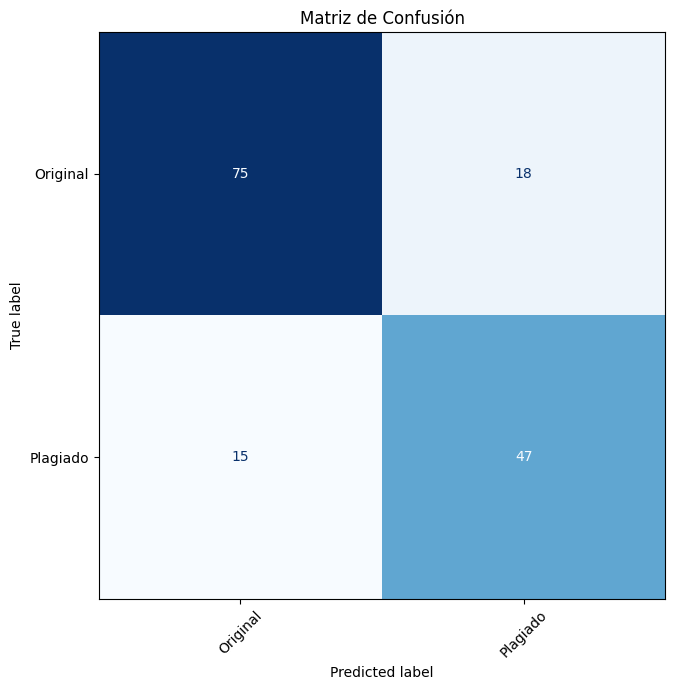


Reporte de clasificación:

              precision    recall  f1-score   support

    Original       0.83      0.81      0.82        93
    Plagiado       0.72      0.76      0.74        62

    accuracy                           0.79       155
   macro avg       0.78      0.78      0.78       155
weighted avg       0.79      0.79      0.79       155



In [58]:

y_pred = (model.predict([x1_test, x2_test]) > 0.5).astype(int).flatten()
labels = ["Original", "Plagiado"]

cm  = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
plt.title("Matriz de Confusión")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

print("\nReporte de clasificación:\n")
print(classification_report(y_test, y_pred, target_names=labels))


In [59]:
model.save("model.h5")